In [30]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt

In [31]:
with open("../../../data/train_test_split/test_folders.json", "r") as train_file:
    test_folders = json.load(train_file)

In [32]:
df = pd.read_csv('../../../data/base_models/gpt4/temperature1_eval.csv')
lisa_sheets = pd.read_csv('../../../data/lisa_sheets.csv')
df = pd.merge(df, lisa_sheets[['id', 'folder']], how='left', on='id')
df = df[df['folder'].isin(test_folders)]
df.head()

,id,mcq_json,rubric,question,option_a,option_b,option_c,option_d,correct_option,content_gpt,...,starts_with_negation,is_question,relevance,ambiguity,gpt_answer,disclosure,difficulty,min_distractor_quality,avg_distractor_quality,folder
31,OIC-328-06-B,{'question': 'Which type of orthosis is primar...,Management of costs,Which type of orthosis is primarily used to im...,Immobilisation Orthoses,Stabilisation Orthoses,Function Orthoses,Cervical Orthoses,a,**Item_parent:** Non-drug therapies and medica...,...,False,True,0.691449,0.881794,a,False,5,2,3,IC-328
32,OIC-328-12-B,{'question': 'What distinguishes thermal medic...,Definition,What distinguishes thermal medicine from hydro...,Thermal medicine uses seawater without medical...,Hydrotherapy involves the external use of any ...,Thalassotherapy is recognized and reimbursed b...,Thermal medicine involves therapies applied du...,d,**Item_parent:** Non-drug therapies and medica...,...,False,True,0.800510,0.620973,d,False,4,1,3,IC-328
33,OIC-328-05-A,{'question': 'What is the primary purpose of a...,Definition,What is the primary purpose of an orthosis in ...,To enhance muscle growth,To supplement a deficient limb or spine,To replace a missing limb,To provide pain relief,b,**Item Parent:** Non-drug therapies and medica...,...,False,True,0.784810,0.754803,b,False,4,1,3,IC-328
34,OIC-328-08-A,{'question': 'What is the primary purpose of a...,Definition,What is the primary purpose of a limb prosthesis?,To enhance the aesthetic appearance of the limb,To replace a missing limb or limb segment,To provide a temporary solution for limb loss,To prevent further limb loss,b,**Item Parent:** Non-drug therapies and medica...,...,False,True,0.769470,0.774903,b,True,5,1,3,IC-328
35,OIC-328-02-A,{'question': 'What is the principal intended a...,Definition,What is the principal intended action of a med...,Pharmacological means,Immunological means,Metabolic means,Non-pharmacological means,d,**Item Parent:** Non-drug therapies and medica...,...,False,True,0.726440,0.689839,d,False,4,1,3,IC-328


In [33]:
len(df)

1524

In [34]:
df['correct_option'].unique()

array(['a', 'd', 'b', 'c', 'option_b', 'option_c'], dtype=object)

In [35]:
# normalize correct_option
df['correct_option'] = df['correct_option'].replace({'option_b': 'b', 'option_c': 'c', 'option_d': 'd', 'option_a': 'a'}) 

# Question mark

In [36]:
# We want to maximize 'True'
question_freqs = {
    'True': round(df['is_question'].sum()/ len(df) * 100, 2),
    'False': round((len(df) - df['is_question'].sum()) / len(df) * 100, 2)
}

question_freqs

{'True': np.float64(100.0), 'False': np.float64(0.0)}

# Negation

In [37]:
# We want to minimze 'True'
starts_with_negation_freqs = {
    'True': round(df['starts_with_negation'].sum() / len(df) * 100, 2),
    'False': round((len(df) - df['starts_with_negation'].sum()) / len(df) * 100, 2)
}

starts_with_negation_freqs

{'True': np.float64(0.0), 'False': np.float64(100.0)}

# Readability

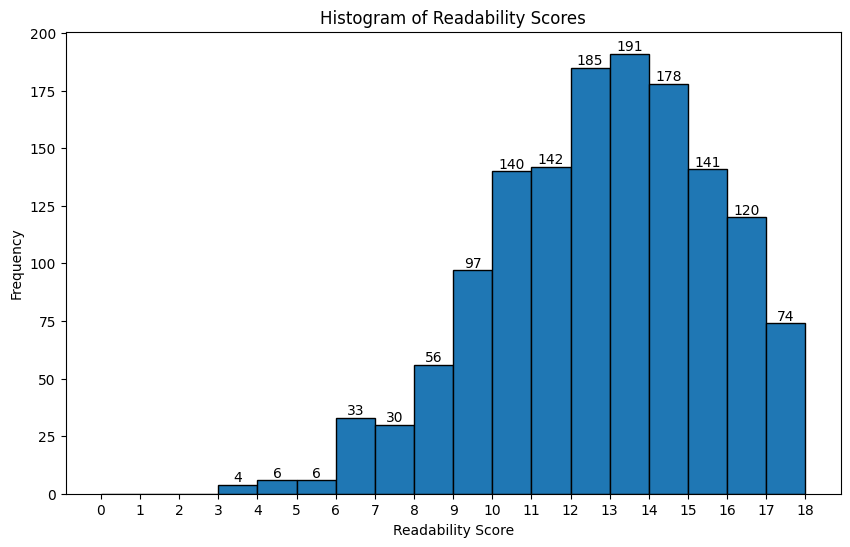

In [38]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['readability'], bins=range(0, 19, 1), edgecolor='black')

# Set x-axis ticks from 0 to 18
plt.xticks(range(0, 19))

# Add frequency labels on top of each bar where frequency > 0
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.show()

In [39]:
df['readability'].describe()

count    1524.000000
mean       13.366749
std         3.392141
min         3.653333
25%        11.130000
50%        13.372727
75%        15.518182
max        27.355000
Name: readability, dtype: float64

# Originality

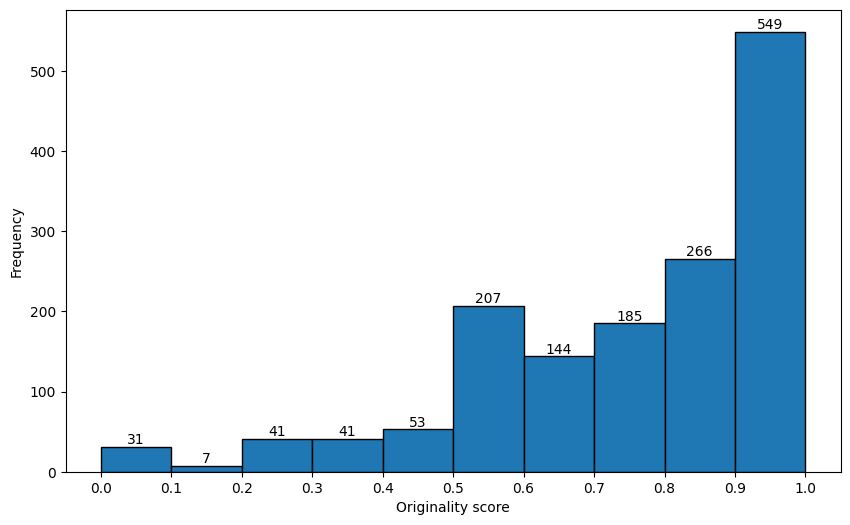

In [40]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['originality'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Originality score')
plt.ylabel('Frequency')
plt.show()

In [41]:
df['originality'].describe()

count    1524.000000
mean        0.761208
std         0.243331
min         0.000000
25%         0.622596
50%         0.800000
75%         1.000000
max         1.000000
Name: originality, dtype: float64

# Answer Length

In [42]:
option_cols = ['option_a', 'option_b', 'option_c', 'option_d']

# Create new columns with word counts for each option column
for col in option_cols:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))

In [43]:
def get_correct_option_rank(row):
    # Get the original word counts for each option
    counts = [
        row['option_a_word_count'],
        row['option_b_word_count'],
        row['option_c_word_count'],
        row['option_d_word_count']
    ]

    # Map correct_option letter to its index (0 for A, 1 for B, etc.)
    letter_to_index = {'A': 0, 'a':0, 'B': 1, 'b':1, 'C': 2, 'c':2, 'D': 3, 'd':3}
    correct_idx = letter_to_index[row['correct_option']]

    # Determine the word count of the correct option
    correct_count = counts[correct_idx]

    # Create an effective counts list:
    # For non-correct options, if their word count equals the correct option's word count,
    # treat them as if they had one extra word.
    effective_counts = []
    for i, count in enumerate(counts):
        if i != correct_idx and count == correct_count:
            effective_counts.append(count + 1)
        else:
            effective_counts.append(count)

    # Sort the option indices by descending effective count.
    ordering = sorted(range(4), key=lambda i: effective_counts[i], reverse=True)

    # Compute the rank as the 1-indexed position of the correct option in the ordering.
    rank = ordering.index(correct_idx) + 1
    return rank

In [44]:
def get_rank_distribution(df):
  rank_distribution = df['correct_option_rank'].value_counts().sort_index()
  rank_distribution = round(rank_distribution / len(df), 2) * 100

  plt.figure(figsize=(8, 6))
  plt.bar(rank_distribution.index, rank_distribution.values, color='skyblue', edgecolor='black')
  plt.xlabel('N (1 = Longest, 4 = Shortest)')
  plt.ylabel('Frequency, %')
  plt.title('How often the correct option is N`th longest')
  plt.xticks([1, 2, 3, 4])
  plt.show()

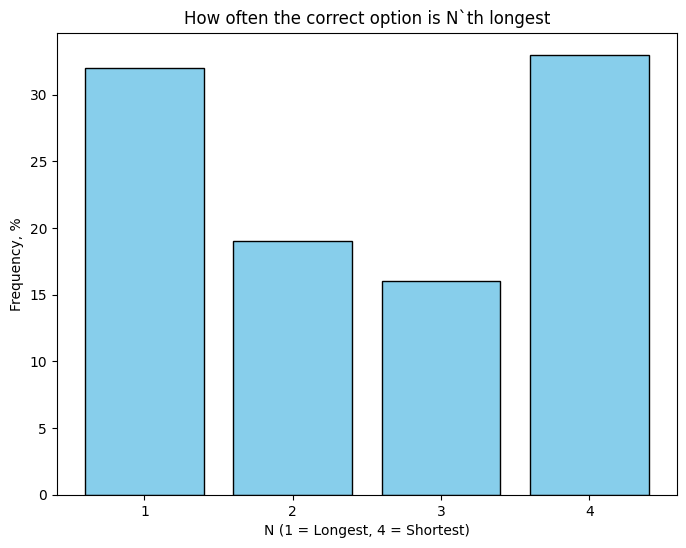

In [45]:
df['correct_option_rank'] = df.apply(get_correct_option_rank, axis=1)
get_rank_distribution(df)

# Disclosure

In [46]:
disclosure_freqs = {
    'True': round((df['disclosure'].sum() / len(df)) * 100, 2),
    'False': round((len(df) - df['disclosure'].sum()) / len(df) * 100, 2)
}

disclosure_freqs

{'True': np.float64(10.37), 'False': np.float64(89.63)}

# Relevance to the input material

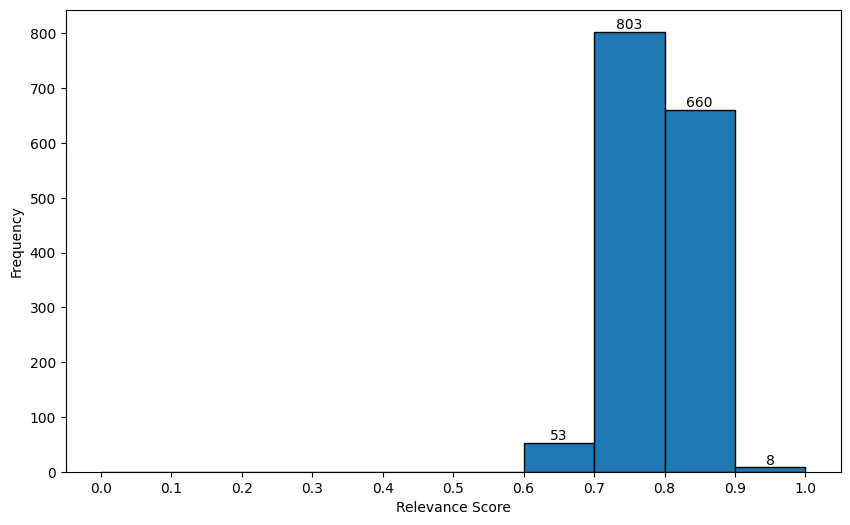

In [47]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['relevance'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

In [48]:
df['relevance'].describe()

count    1524.000000
mean        0.790685
std         0.046347
min         0.611226
25%         0.762342
50%         0.793469
75%         0.823016
max         0.935077
Name: relevance, dtype: float64

# Ambiguity (cosine similarity)

Text(0.5, 1.0, 'Distribution of Ambiguity')

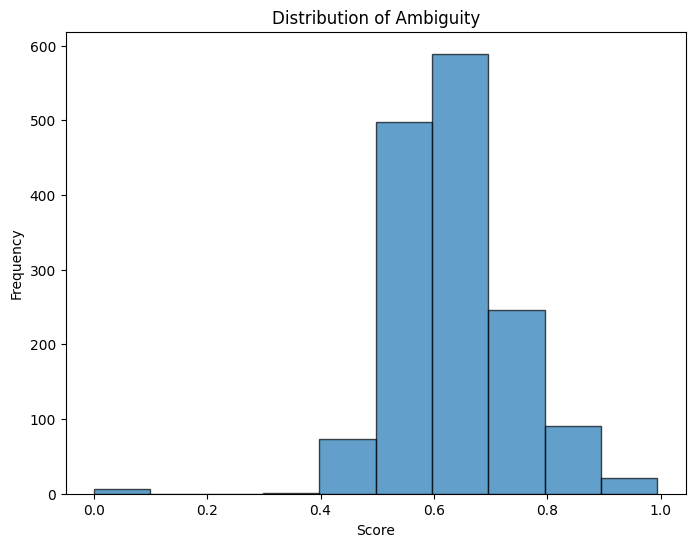

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(df['ambiguity'], bins=10, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Ambiguity")

In [50]:
df['ambiguity'].describe()

count    1524.000000
mean        0.632848
std         0.105204
min         0.000000
25%         0.564952
50%         0.622128
75%         0.690870
max         0.994638
Name: ambiguity, dtype: float64

# Difficulty (judge LLM)

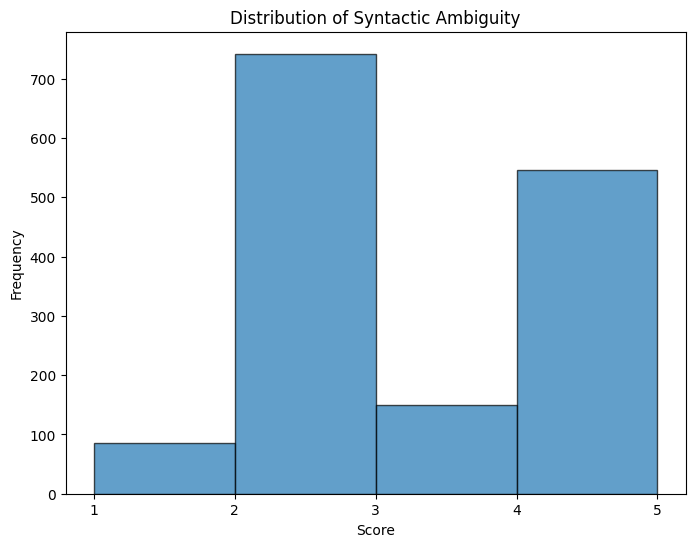

In [51]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['difficulty'], bins=np.arange(1, 6), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Syntactic Ambiguity")
plt.xticks(range(1, 6))

# Show the plot
plt.show()

In [52]:
df['difficulty'].describe()

count    1524.000000
mean        2.953412
std         1.286245
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: difficulty, dtype: float64

# Answerability
can judge model answer the generated question with context provided?

In [53]:
df['gpt_answer'].unique()

array(['a', 'd', 'b', 'c'], dtype=object)

In [54]:
df['correct_option'].unique()

array(['a', 'd', 'b', 'c'], dtype=object)

In [55]:
answerability_freqs = {
    'True': round((df['correct_option'] == df['gpt_answer']).sum() / len(df) * 100, 2), 
    'False': round((len(df) - (df['correct_option'] == df['gpt_answer']).sum()) / len(df) * 100, 2)
}

answerability_freqs

{'True': np.float64(99.74), 'False': np.float64(0.26)}

# Distractors Quality

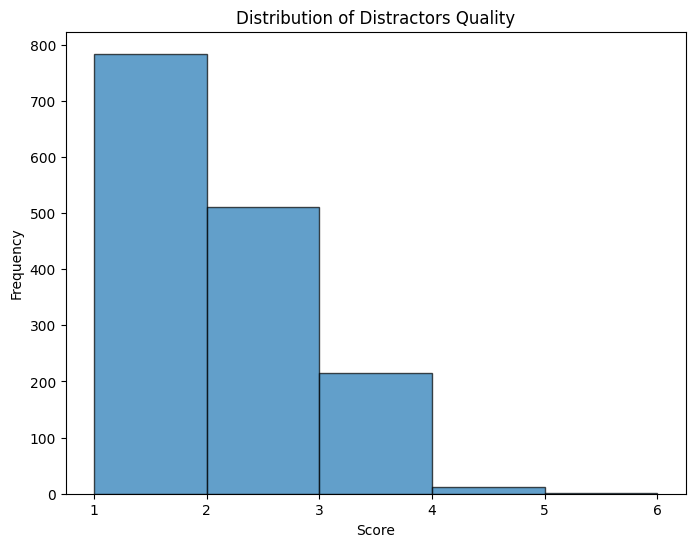

In [56]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['min_distractor_quality'], bins=np.arange(1, 7), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Distractors Quality")
plt.xticks(range(1, 7))

# Show the plot
plt.show()

In [57]:
df['min_distractor_quality'].describe()

count    1524.000000
mean        1.646325
std         0.757700
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: min_distractor_quality, dtype: float64

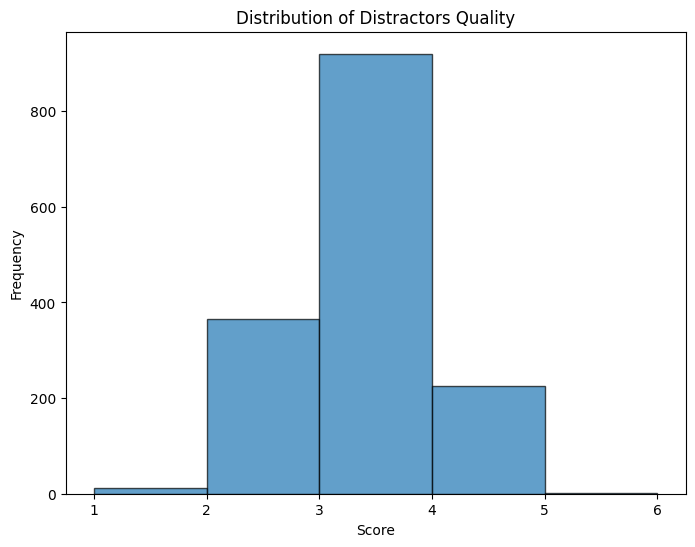

In [58]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['avg_distractor_quality'], bins=np.arange(1, 7), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Distractors Quality")
plt.xticks(range(1, 7))

# Show the plot
plt.show()

In [59]:
df['avg_distractor_quality'].describe()

count    1524.000000
mean        2.894357
std         0.641113
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: avg_distractor_quality, dtype: float64